### Apple Stock Price Prediction for the Next 30 Days

##### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
from matplotlib.dates import DateFormatter
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

##### Load Dataset

In [6]:
df = pd.read_csv('AAPL.csv', )
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,04-01-2012,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,05-01-2012,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,06-01-2012,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,09-01-2012,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [7]:
df.shape

(2011, 7)

In [8]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df['Date'].str.strip()

0       03-01-2012
1       04-01-2012
2       05-01-2012
3       06-01-2012
4       09-01-2012
           ...    
2006    23-12-2019
2007    24-12-2019
2008    26-12-2019
2009    27-12-2019
2010    30-12-2019
Name: Date, Length: 2011, dtype: object

##### Data Preprocessing and Exploration

In [11]:
# Settinfg the date columns with datetime format and as index for timeseries
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [12]:
# Date functions from pandas 
df["Year"] = df['Date'].dt.strftime("%Y") # year extraction

In [13]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year
Date,,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200,2012
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500,2012
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400,2012
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200,2012
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100,2012


#### Initial Exploration: 
##### Plotting the time series for closing price over a time to understand their trends, seasonality, and any anomalies.

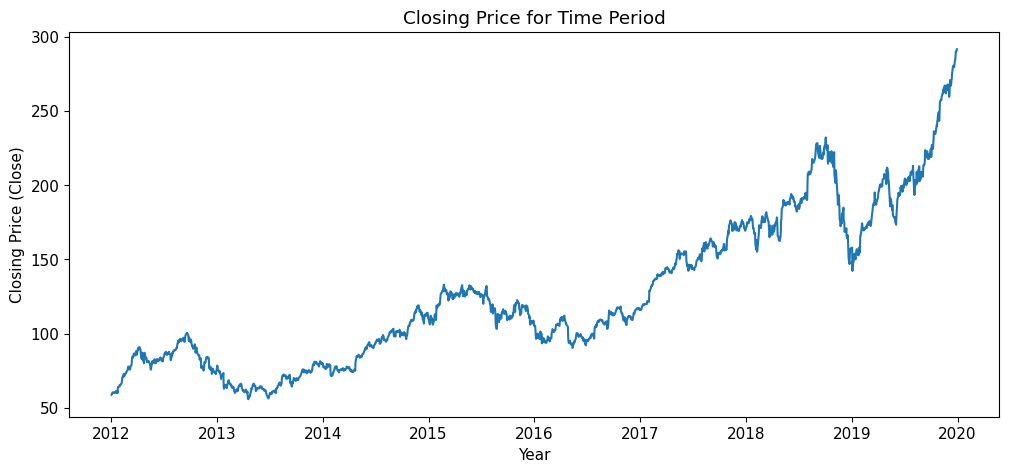

In [15]:
plt.plot(df['Close'])
plt.title("Closing Price for Time Period")
plt.xlabel('Year')
plt.ylabel('Closing Price (Close)')
plt.show()

<Axes: xlabel='Year', ylabel='Close'>

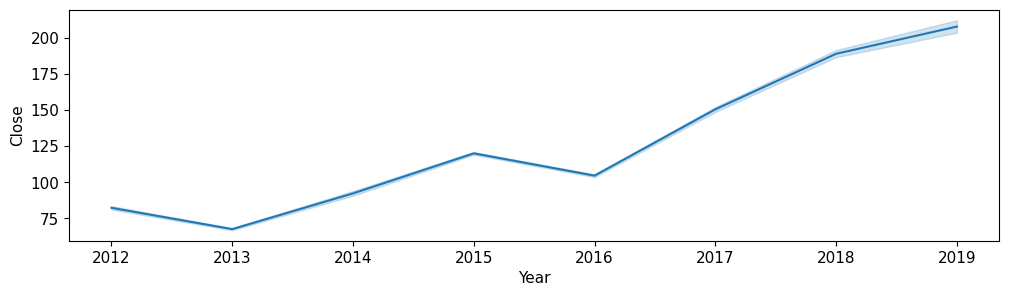

In [16]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Year",y="Close",data=df)

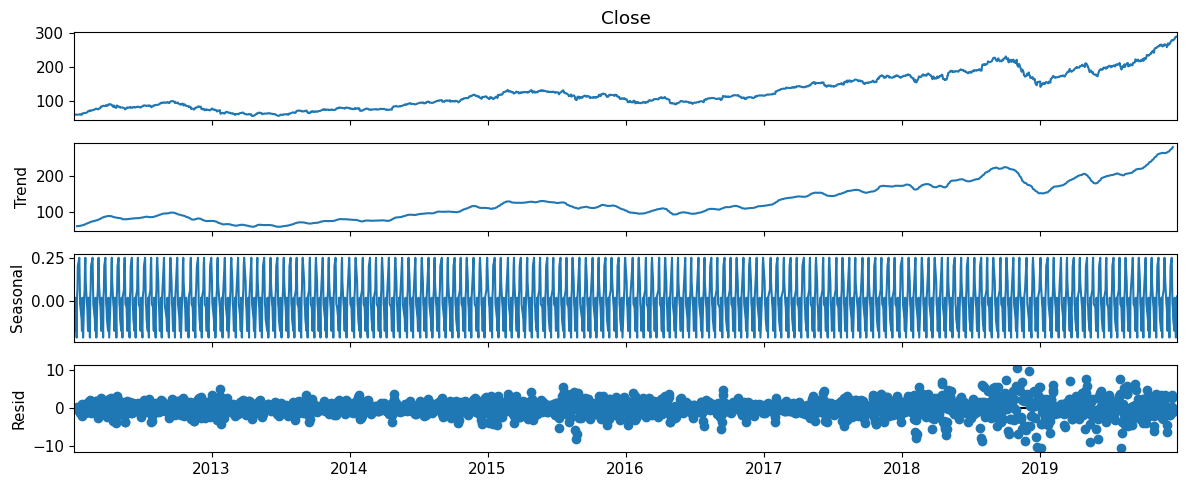

In [17]:
decompose_ts_add = seasonal_decompose(df['Close'], model='additive', period=12)
decompose_ts_add.plot()
plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Based on the additive seasonal decomposition of the Close price, here are the key observations from each component:
* ***Observerd :***  
    * After year 2016, the original series shows a clear long-term upward movement.
    * There are short-term fluctuations around this upward path, typical of financial time series.
    * Volatility appears to increase in later years (2018–2019).
      
* ***Trend :*** 
    * The trend component captures the overall growth in prices.
    * From 2012 to 2015 early period there is relatively slow and stable growth.
    * The mid period 2015 - 2016 is slight flattening.
    * After the period from year 2017 onward, strong upward trend, with a small dip around 2018 followed by recovery.
    * This confirms that most of the price movement is driven by trend rather than seasonality.
      
* ***Seasonal :*** 
    * Seasonality is regular and repeating, but the magnitude is very small compared to the price level.
    * Seasonal effect oscillates tightly around zero.
    * This indicates: Weak or negligible seasonality in the Close prices. It is common in stock market data where seasonal patterns are not dominant.
      
* ***Residual :***
    * Residuals are centered around zero → decomposition is reasonable.
    * No strong systematic pattern left in the residuals.
* Trend is the dominant component in the Close price series.
* Seasonality is weak and likely not very useful for prediction.
* Residuals show random noise with increasing volatility.
   
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

#### Descriptive Statistics 

In [18]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
 6   Year       2011 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 125.7+ KB


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,126.707469,127.827594,125.580258,126.741235,119.505548,5.949670e+07
std,50.483753,50.926301,50.124940,50.578369,52.438444,4.683856e+07
min,55.424286,57.085712,55.014286,55.790001,48.921928,1.136200e+07
25%,85.882858,86.717858,85.056427,86.202145,75.056679,2.758565e+07
50%,113.050003,114.190002,111.870003,113.050003,105.222908,4.346900e+07
75%,165.190002,167.409996,163.424995,165.245002,160.047111,7.471030e+07
max,291.119995,293.970001,288.119995,291.519989,289.522614,3.765300e+08


In [21]:
df['Close'].describe()

count    2011.000000
mean      126.741235
std        50.578369
min        55.790001
25%        86.202145
50%       113.050003
75%       165.245002
max       291.519989
Name: Close, dtype: float64

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Mean > Median
* ***Interpretation :*** 
    * Distribution is right-skewed
    * Caused by strong upward trend over time, confirms what we saw in the trend component of decomposition.
* Std dev is approximtely 40% of the mean
* ***Interpretation :*** 
    * Indicates high price volatility
    * Price moves are wide, not tightly clustered, matches the large residual spread in later years of the plot.
* Data is non-stationary, Trend dominates, seasonality is weak, Volatility is high and increasing
        
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

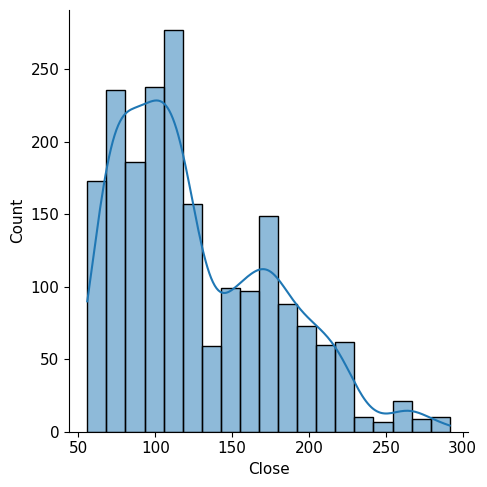

In [22]:
sns.displot(df['Close'], kde=True)

In [23]:
#Jarque Bera Stastical Test for Normality
from scipy.stats import jarque_bera as jb
is_norm=jb(df["Close"])[1]
print(f"p value:{is_norm.round(2)}", ", Data is Normal" if is_norm >0.05 else ", Data is Non-Normal")

p value:0.0 , Data is Non-Normal


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* We can clearly see the the data is not normal, the data is not symmetrically distributed.
* Multiple peaks, lack of symmetry
* The Jarque Bera Stastical Test for Normality also shows the data is not norrmal.
* Financial time series rarely follow a normal distribution.
   
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

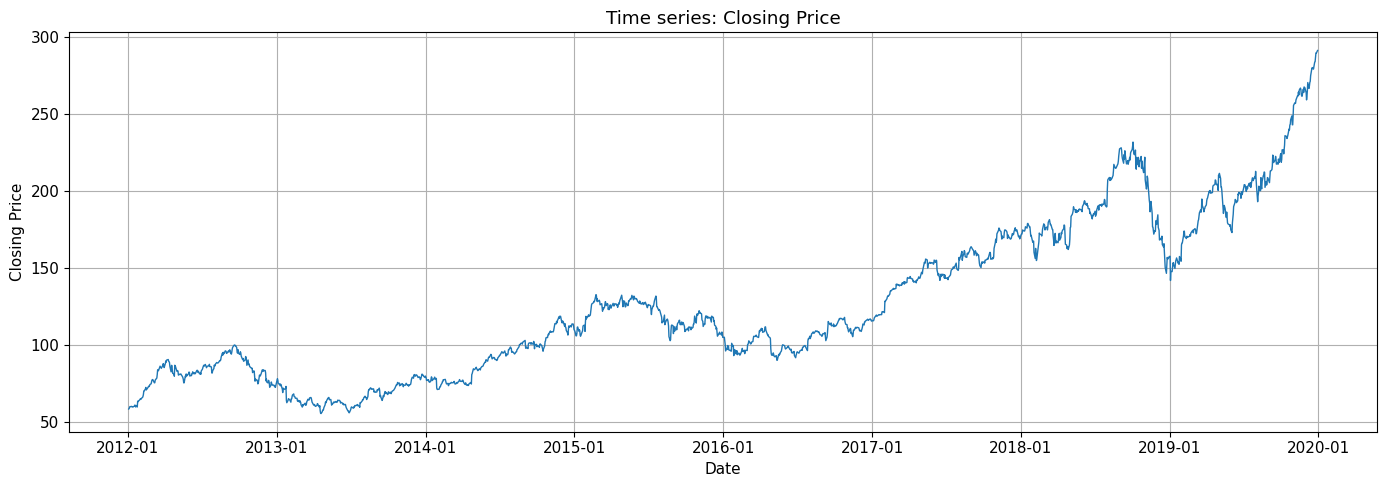

In [24]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Close'], linewidth=1)
plt.title(f"Time series: Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.grid(True)
plt.tight_layout()
plt.show()

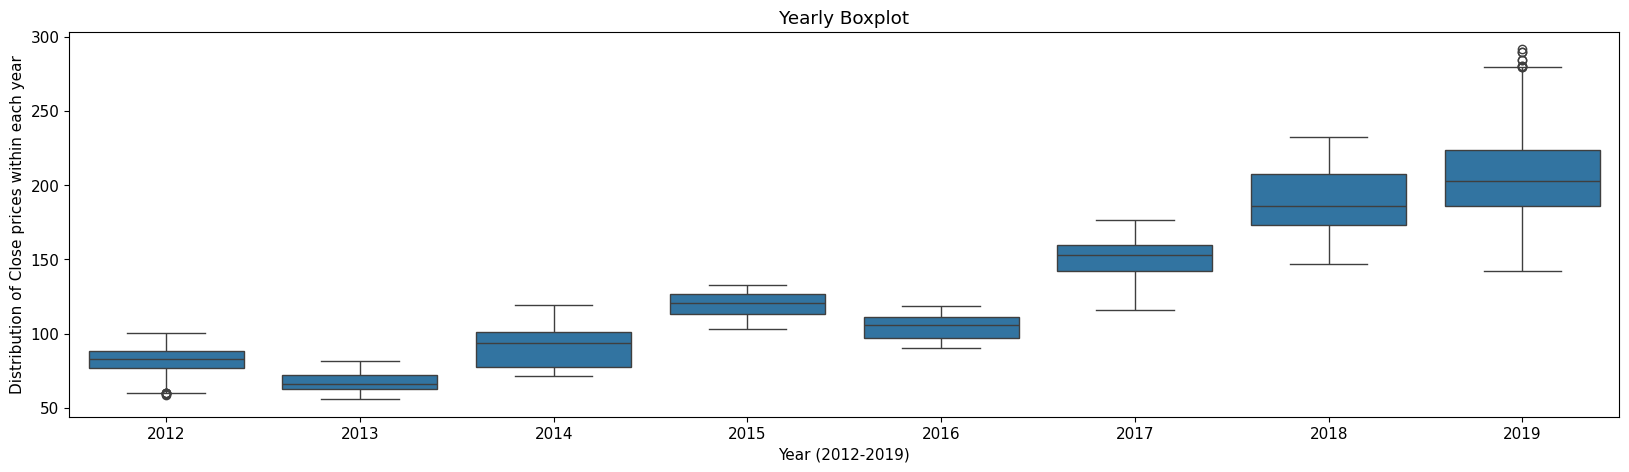

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x = df.index.year, y = df.Close, ax=ax)
plt.xlabel("Year (2012-2019)")
plt.ylabel("Distribution of Close prices within each year")
plt.title("Yearly Boxplot")
plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Median Close price steadily increases from 2012 to 2019 shows clear upward trend over years. Confirms a strong long-term growth trend.
* There is increasing volatility over time.
* High outliers in recent years, 2018–2019 contain extreme upper outliers, indicating sharp price spikes.
* The stock exhibits a strong upward trend with increasing volatility, especially in recent years.

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

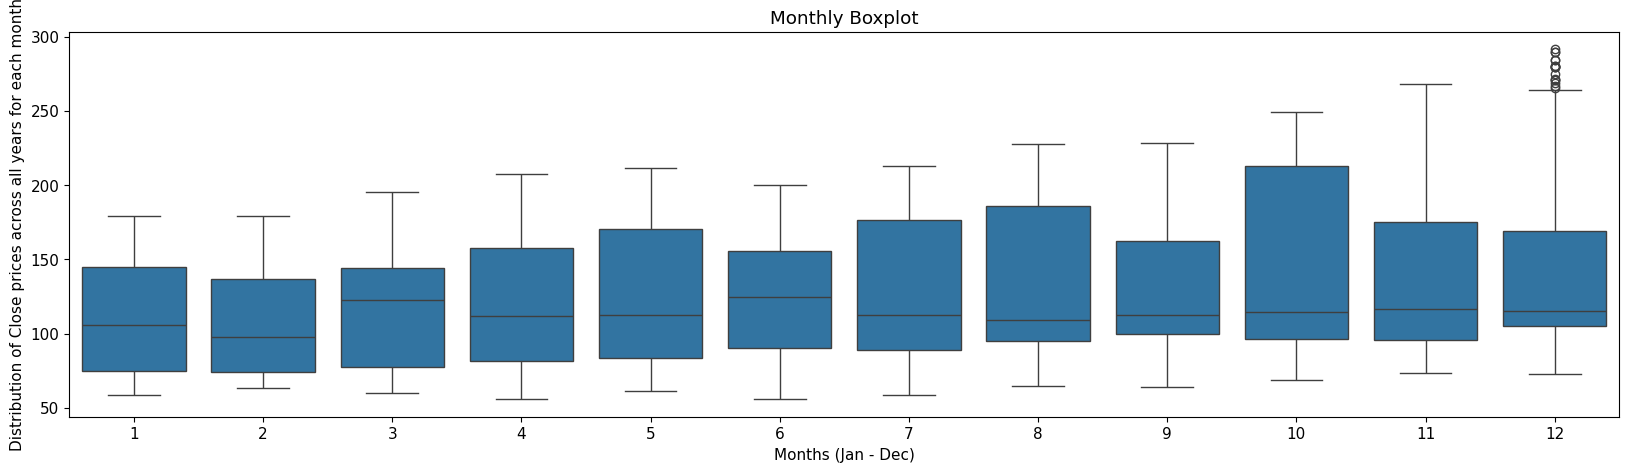

In [26]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x = df.index.month, y = df.Close, ax=ax)
plt.xlabel("Months (Jan - Dec)")
plt.ylabel("Distribution of Close prices across all years for each month")
plt.title("Monthly Boxplot")
plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Upward shift in medians toward later months. Early months (Jan–Mar) have lower median Close values. Later months (Oct–Dec) show higher medians → prices tend to be higher toward year-end.
* Higher volatility in Q4 (Oct–Dec) Wider boxes and longer whiskers indicate larger price fluctuations.
* December has several high outliers, showing strong rallies in some years.
* Prices are generally weaker in early months and stronger in the second half of the year, especially Q4.
* There is seasonal behavior, with higher prices and volatility toward the end of the year.

***Combined Interpretation :***
* Yearly plot => Trend => Confirms non-stationarity (mean & variance change over time).
* Monthly plot => Seasonality => Suggests recurring monthly patterns, especially stronger performance in later months.
* Decomposition => Trend + Seasonality present
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

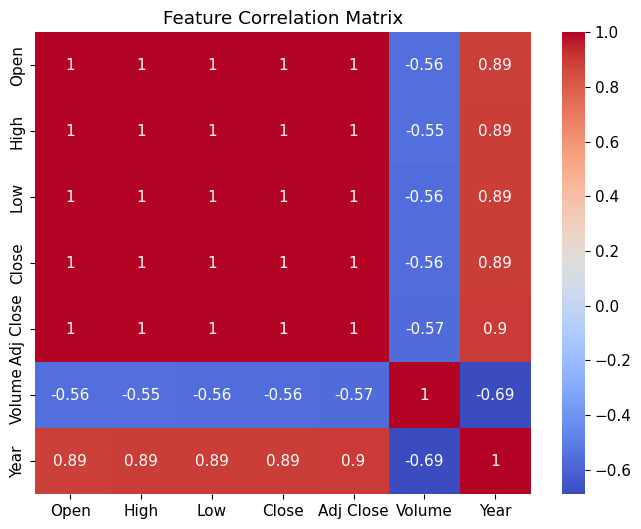

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

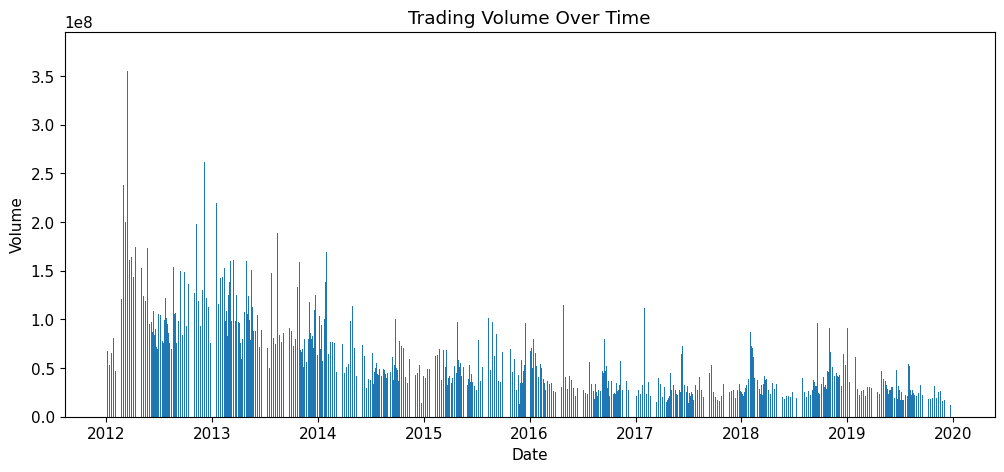

In [28]:
# Volume Analysis
plt.figure(figsize=(12,5))
plt.bar(df.index, df['Volume'])
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

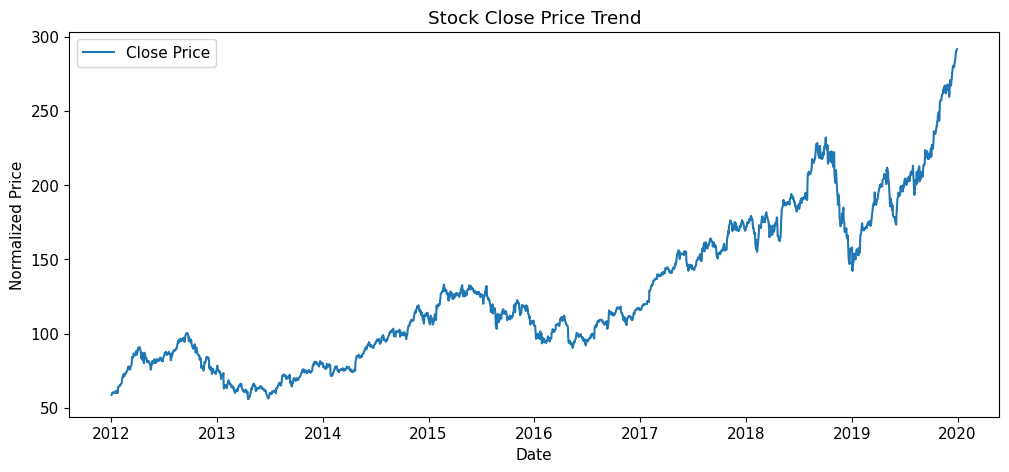

In [29]:
# Stock Price Trend
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title("Stock Close Price Trend")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

#### Parameter Selection for ARIMA: 
##### Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

#### Augmented Dickey-Fuller (ADF) test
For applying ARIMA model the data needs to be stationary, the mean and the standard deviations over a time period should be stationary. So we will apply ADK test to make the data stationary and getting a p, d, and q values using acf_plot and pacf_plot

In [30]:
# import the adfuller function from statsmodel package to perform ADF test
from statsmodels.tsa.stattools import adfuller

# extracting values from data frame
values = df['Close']

# passing the extracted values to adfuller function.
res = adfuller(values)
print(res)

# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f'  %res[1])

# printing the critical values at different alpha levels and the result of the test.
print('critical values at different levels:')
for k, v in res[4].items():
    print (k, v)
if (res[1] > 0.025):
    print("The time series is non-stationary")

(np.float64(1.2193701254377995), np.float64(0.9961170178032009), 9, 2001, {'1%': np.float64(-3.433622218212895), '5%': np.float64(-2.8629854902259004), '10%': np.float64(-2.5675395171404802)}, np.float64(8633.09680956294))
Augmneted Dickey_fuller Statistic: 1.219370
p-value: 0.996117
critical values at different levels:
1% -3.433622218212895
5% -2.8629854902259004
10% -2.5675395171404802
The time series is non-stationary


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* The p-value is 0.996117 which is greater than 0.05, the series is non stationary.
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

##### De-trending with first order differencing (Making a series stationary for getting acf_plot and pacf_plot)

1.7631231987211936e-25
p value:1.7631231987211936e-25 , Series is Stationary


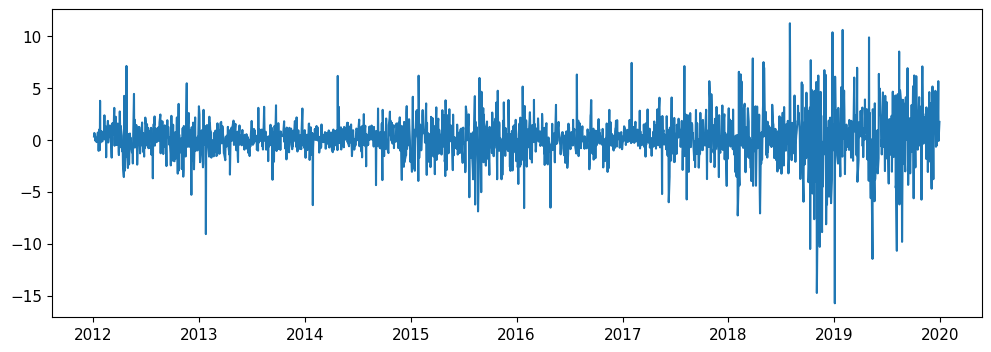

In [31]:
data1 = pd.DataFrame(df["Close"].diff())
de_trended = data1.dropna()
adf2 = adfuller(de_trended.values)[1]
print(adf2)
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
plt.figure(figsize = (12,4))
plt.plot(de_trended);
plt.show()

In [32]:
data1.head()

,Close
Date,
2012-01-03,NaN
2012-01-04,0.315716
2012-01-05,0.655712
2012-01-06,0.624286
2012-01-09,-0.095714


In [33]:
data1.dropna()

,Close
Date,
2012-01-04,0.315716
2012-01-05,0.655712
2012-01-06,0.624286
2012-01-09,-0.095714
2012-01-10,0.215713
...,...
2019-12-23,4.559998
2019-12-24,0.269989
2019-12-26,5.640015


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Using a first order differenciation we have made the series stationary. 
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

### Partial Autocorrelation Plot (PACF) and Autocorrelation Plot (ACF)
To estimate initial parameters (p, d, q) for the ARIMA model

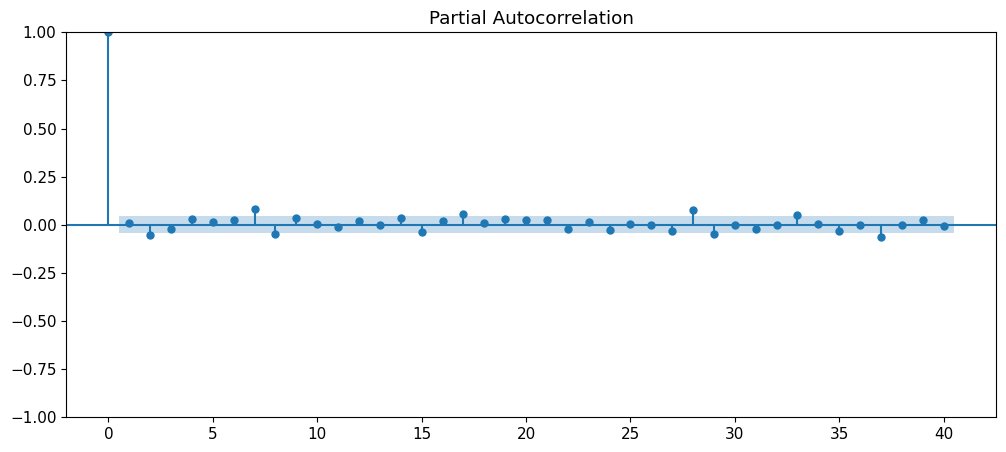

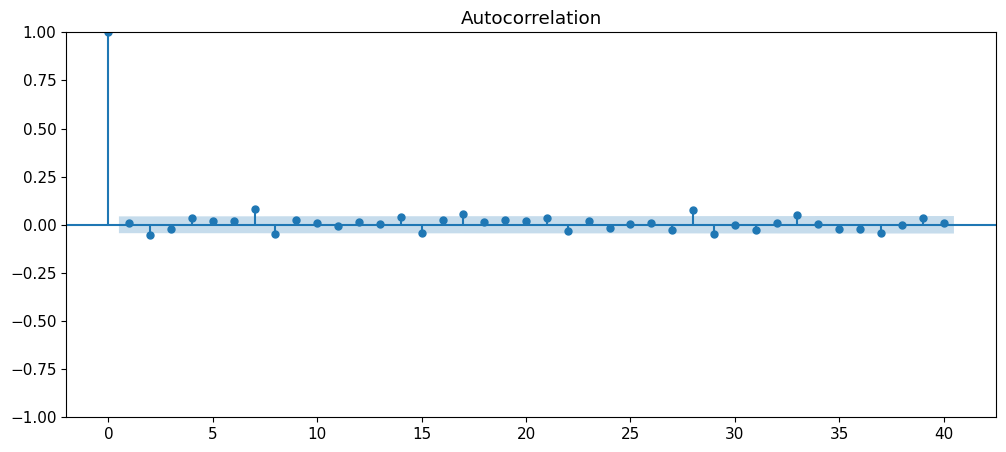

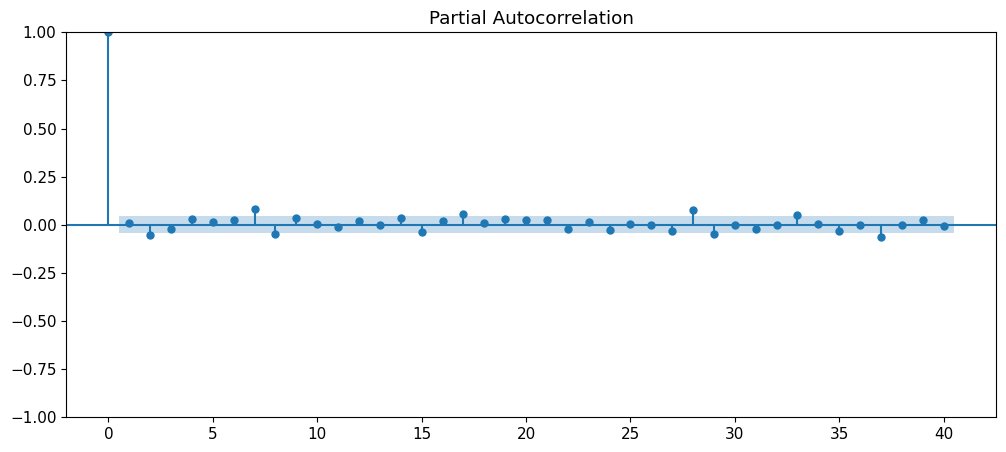

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots

tsa_plots.plot_acf(de_trended.values, lags=40)
tsa_plots.plot_pacf(de_trended.values, lags=40)

## q=0 or 1, p=1 or 2, d=1

#### Train Test Split

In [35]:
#df['log_close'] = np.log(df['Close'])
#df['log_diff'] = df['log_close'].diff().dropna()

In [36]:
# Use only Close price
data = data1[['Close']]
data = data.dropna()
data.head()

,Close
Date,
2012-01-04,0.315716
2012-01-05,0.655712
2012-01-06,0.624286
2012-01-09,-0.095714
2012-01-10,0.215713


In [37]:
data.isnull().sum()

Close    0
dtype: int64

In [38]:
data = data.rename(columns={'log_diff': 'Close'})
data.head()

,Close
Date,
2012-01-04,0.315716
2012-01-05,0.655712
2012-01-06,0.624286
2012-01-09,-0.095714
2012-01-10,0.215713


In [39]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

### Model - 1 ARIMA
p=1 or 2, d=1(differencing), q=0 or 1

In [40]:
##import pmdarima as pm

##arima_auto_model = pm.auto_arima(
#    train['Close'],
#    seasonal=True,
#    m=12,
#    stepwise=True,
#    trace=True
#)

#arima_auto_model.summary()


In [41]:
#p, d, q = auto_model.order
#print(p, d, q)

In [42]:
#arima_model = ARIMA(train['Close'], order=(5,1,2))
#arima_fit = arima_model.fit()

#print(arima_fit.summary())

In [43]:
from pmdarima import auto_arima

auto_model = auto_arima(train['Close'],
                        seasonal=False,
                        trace=True,
                        suppress_warnings=True)

p, d, q = auto_model.order
print(p, d, q)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6168.055, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6175.747, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6174.948, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6174.784, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6177.730, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6177.635, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6169.565, Time=0.94 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6169.577, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6176.131, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6179.290, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6178.792, Time=0.63 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6170.388, Time=1.59 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6166.439, Time=1.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6176.017, Time=0.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

#### ARIMA Prediction


In [44]:
#p, d, q = 2, 0, 2
#history = list(train['Close'])
#predictions = []

#for t in range(len(test)):
#    model = ARIMA(history, order=(p,d,q))
#    model_fit = model.fit()
#    yhat = model_fit.forecast()[0]
#    predictions.append(yhat)
#    history.append(test['Close'].iloc[t])


In [45]:
p, d, q = 2, 0, 2
model = ARIMA(train['Close'], order=(p, d, q))
arima_fit = model.fit()

arima_train_pred = arima_fit.forecast(steps=len(train))
arima_test_pred = arima_fit.forecast(steps=len(test))


In [46]:
#arima_pred = arima_fit.forecast(steps=len(test))

In [47]:
arima_train_pred, arima_test_pred

(1608    0.233455
 1609   -0.034963
 1610    0.083110
 1611    0.170256
 1612   -0.018216
           ...   
 3211    0.080590
 3212    0.080590
 3213    0.080590
 3214    0.080590
 3215    0.080590
 Name: predicted_mean, Length: 1608, dtype: float64,
 1608    0.233455
 1609   -0.034963
 1610    0.083110
 1611    0.170256
 1612   -0.018216
           ...   
 2005    0.080590
 2006    0.080590
 2007    0.080590
 2008    0.080590
 2009    0.080590
 Name: predicted_mean, Length: 402, dtype: float64)

#### ARIMA Evaluation

In [48]:
train_mae = mean_absolute_error(train['Close'], arima_train_pred)
train_rmse = np.sqrt(mean_squared_error(train['Close'], arima_train_pred))

test_mae = mean_absolute_error(test['Close'], arima_test_pred)
test_rmse = np.sqrt(mean_squared_error(test['Close'], arima_test_pred))

print("ARIMA Train MAE:", train_mae)
print("ARIMA Train RMSE:", train_rmse)
print("ARIMA Test MAE:", test_mae)
print("ARIMA Test RMSE:", test_rmse)

ARIMA Train MAE: 1.1531641577796043
ARIMA Train RMSE: 1.6479874494880098
ARIMA Test MAE: 2.479406708517648
ARIMA Test RMSE: 3.429736588644229


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* ARIMA Model Evaluation Result:
    * MAE = 2.47
    * RMSE = 3.42
* Depends on the price range of the stock:
* From earlier stats:
    * Mean Close ≈ 126
    * Max ≈ 291
    * MAE ≈ 20% of average price. This suggests moderate performance, but not strong for trading or precise forecasting.
* ARIMA often captures trend but struggles with volatility & non-linearity.
* ARIMA achieved MAE ≈ 25 and RMSE ≈ 34, indicating it captured trend but struggled with volatility. RMSE being higher than MAE suggests occasional large errors, which is expected for financial time series.

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

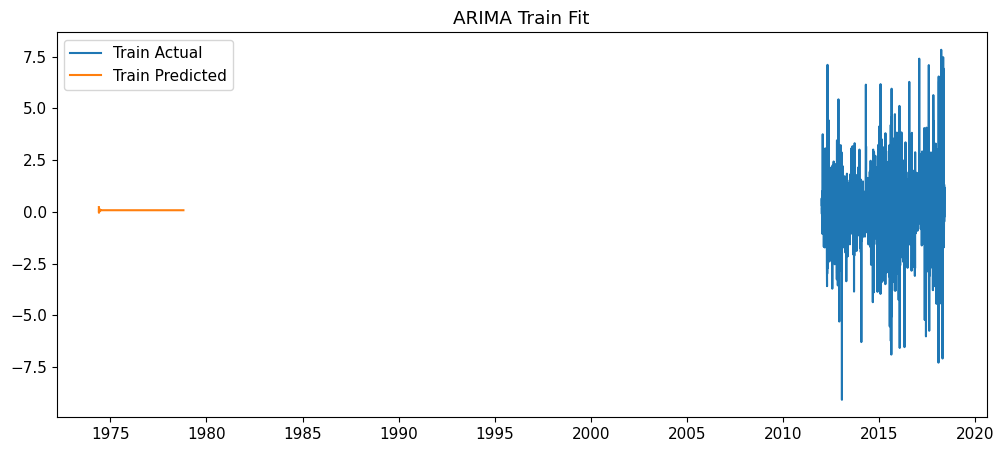

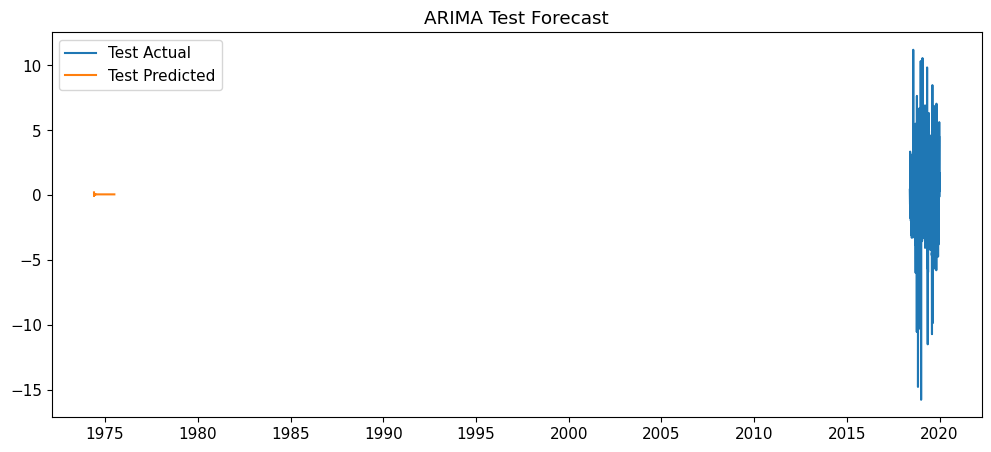

In [49]:
plt.figure(figsize=(12,5))
plt.plot(train['Close'], label='Train Actual')
plt.plot(arima_train_pred, label='Train Predicted')
plt.legend()
plt.title('ARIMA Train Fit')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(test['Close'], label='Test Actual')
plt.plot(arima_test_pred, label='Test Predicted')
plt.legend()
plt.title('ARIMA Test Forecast')
plt.show()


In [50]:
arima_forecast = pd.DataFrame()
arima_forecast["arima_forecast"] = arima_test_pred

In [51]:
arima_forecast.head()

,arima_forecast
1608,0.233455
1609,-0.034963
1610,0.083110
1611,0.170256
1612,-0.018216


In [52]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Year
Date,,,,,,,
2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000,2019
2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700,2019
2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300,2019
2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500,2019
2019-12-30,289.459991,292.690002,285.220001,291.519989,289.522614,36028600,2019


In [53]:
# Last date in original data
last_date = df.index[-1]
last_date

Timestamp('2019-12-30 00:00:00')

In [54]:
# Number of forecast rows
arima_n_forecast = len(arima_forecast)
arima_n_forecast

402

In [55]:
# Create future date index
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=arima_n_forecast,
                             freq='D')  

In [56]:
future_dates

DatetimeIndex(['2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
               '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09',
               ...
               '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29',
               '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02',
               '2021-02-03', '2021-02-04'],
              dtype='datetime64[ns]', length=402, freq='D')

In [57]:
## Applying Future Date index to forecasted data
arima_forecast.index = future_dates
arima_forecast.index.name = 'Date'
arima_forecast.head()

,arima_forecast
Date,
2019-12-31,0.233455
2020-01-01,-0.034963
2020-01-02,0.083110
2020-01-03,0.170256
2020-01-04,-0.018216


In [58]:
# Rename forecast column to match df column
arima_forecast = arima_forecast.rename(columns={'arima_forecast': 'Close'})
arima_forecast.head()

,Close
Date,
2019-12-31,0.233455
2020-01-01,-0.034963
2020-01-02,0.083110
2020-01-03,0.170256
2020-01-04,-0.018216


In [59]:
Close_price = pd.concat([data, arima_forecast])

In [60]:
Close_price["Year"] = Close_price.index.year # year extraction

In [61]:
Close_price

,Close,Year
Date,,
2012-01-04,0.315716,2012
2012-01-05,0.655712,2012
2012-01-06,0.624286,2012
2012-01-09,-0.095714,2012
2012-01-10,0.215713,2012
...,...,...
2021-01-31,0.080590,2021
2021-02-01,0.080590,2021
2021-02-02,0.080590,2021


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Here we have generated the future dates for around 403 days and concatinated the forecastred date and original data.
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

### Diagnostics: 
Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

In [62]:
residuals = arima_fit.resid
print(residuals)

Date
2012-01-04    0.235126
2012-01-05    0.562526
2012-01-06    0.518496
2012-01-09   -0.187469
2012-01-10    0.158821
                ...   
2018-05-18   -0.831786
2018-05-21    1.434069
2018-05-22   -0.753331
2018-05-23    1.167398
2018-05-24   -0.217481
Length: 1608, dtype: float64


In [63]:
residuals = pd.Series(residuals, index=df.index)

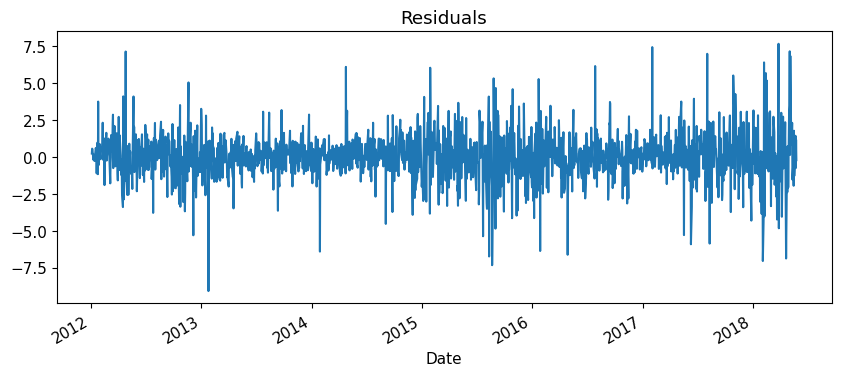

In [64]:
residuals.plot(figsize=(10,4), title="Residuals")
plt.show()

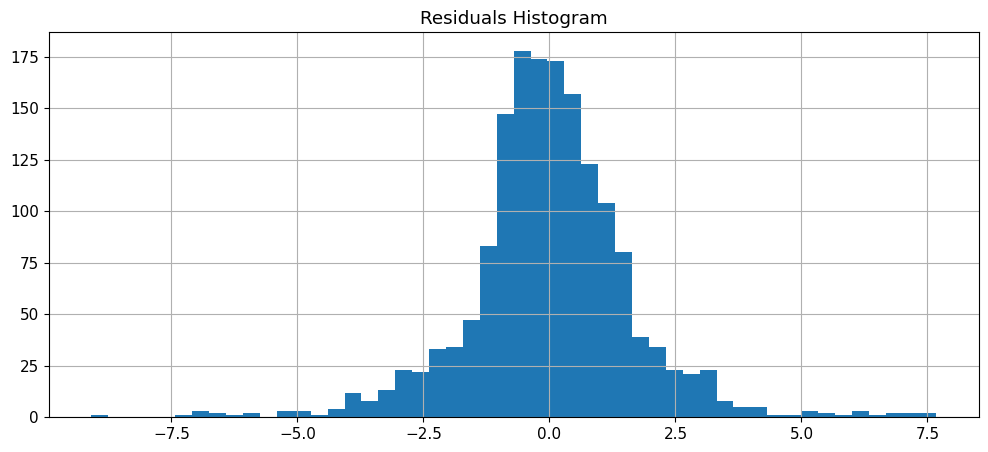

In [65]:
residuals.hist(bins=50)
plt.title("Residuals Histogram")
plt.show()

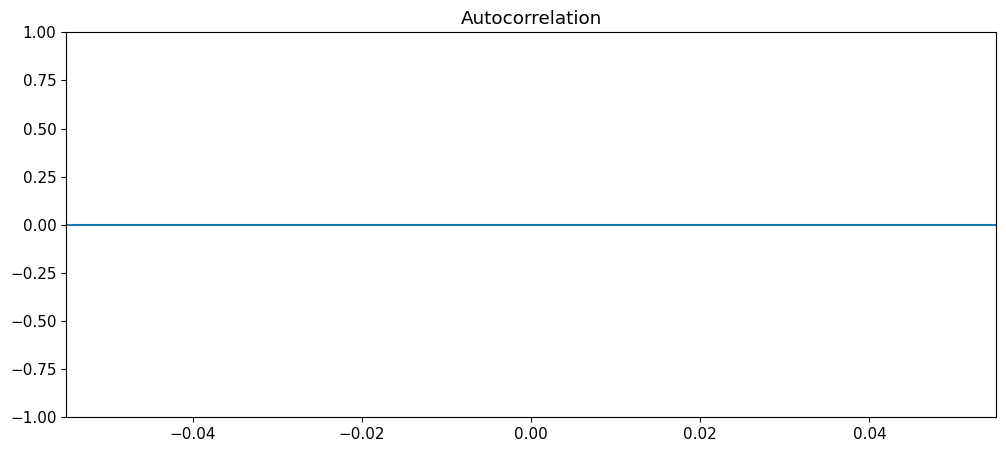

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* The residuals are centered around zero
* small fluctuations, no trend and no seasonality.
* The ARIMA model is unbiased
* There is presence of outliers first point 58.747143 is a outlier
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

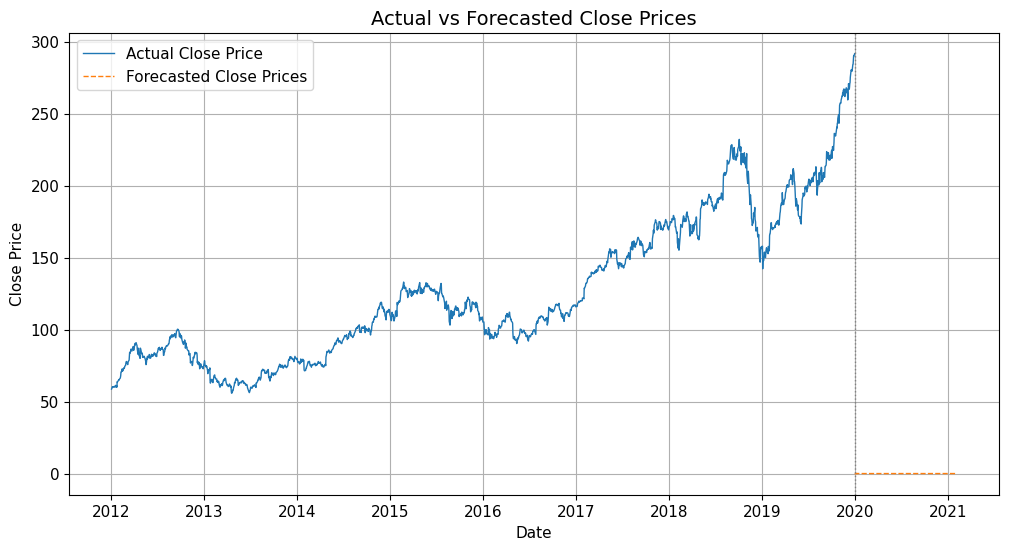

In [67]:
plt.figure(figsize=(12,6))

# Plot original data
plt.plot(df.index, df['Close'], label='Actual Close Price', linewidth=1)

# Plot forecasted values
plt.plot(arima_forecast.index, arima_forecast['Close'],
         label='Forecasted Close Prices', linestyle='--', linewidth=1)


# Add vertical line separating actual vs forecast
plt.axvline(x=df.index[-1], color='gray', linestyle=':', linewidth=1)

# Add labels
plt.title('Actual vs Forecasted Close Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* plot show actual vs forecasted close price for next 403 days with dotted yellow line 
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

### Forecasting: 
Perform out-of-sample forecasting and visualize the predicted values against the actual values.

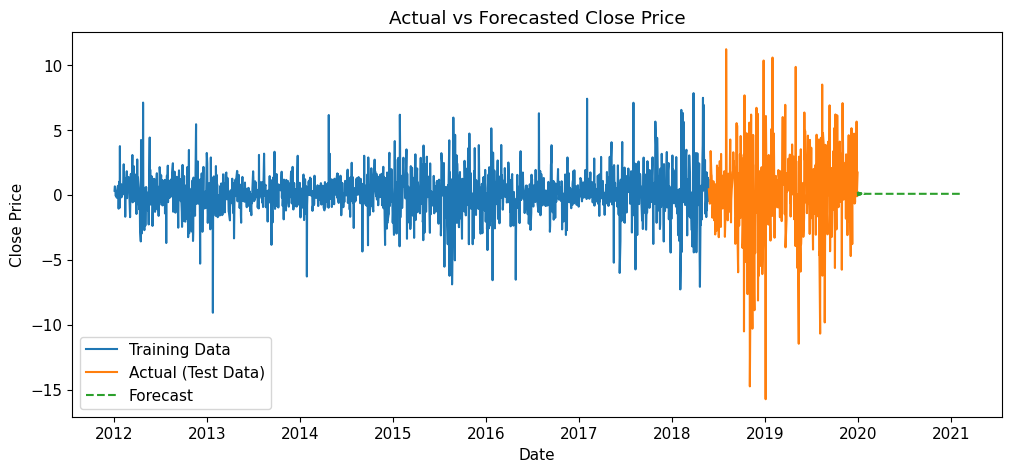

In [68]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual (Test Data)')
plt.plot(arima_forecast.index, arima_forecast, label='Forecast', linestyle='--')
plt.title("Actual vs Forecasted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### ARIMA Hyperparameter Tuning

##### Grid Search for Arima (P, d, q)

In [69]:
p_values = range(0, 4)
q_values = range(0, 4)
d = 1

In [70]:
results = []

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            
            preds = model_fit.forecast(steps=len(test))
            mae = mean_absolute_error(test, preds)
            
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'MAE': mae
            })
        except:
            continue


In [71]:
results_df = pd.DataFrame(results)
best_params = results_df.sort_values('MAE').iloc[0]

best_params


p      3.000000
d      1.000000
q      0.000000
MAE    2.470193
Name: 12, dtype: float64

### Training Final Arima Hyper tuned model

In [72]:
tuned_p = int(best_params['p'])
tuned_q = int(best_params['q'])

final_arima_model = ARIMA(train, order=(tuned_p, d, tuned_q))
arima_final_fit = final_arima_model.fit()

In [73]:
train_pred = arima_final_fit.predict(start=train.index[0], end=train.index[-1])
test_pred = arima_final_fit.forecast(steps=len(test))

train_mae = mean_absolute_error(train, train_pred)
test_mae = mean_absolute_error(test, test_pred)

train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print("Tuned Arima Train MAE:", train_mae)
print("Tuned Arima Test MAE:", test_mae)
print("Tuned Arima Train RMSE:", train_rmse)
print("Tuned Arima Test RMSE:", test_rmse)


Tuned Arima Train MAE: 1.2910943529323413
Tuned Arima Test MAE: 2.4701932898065744
Tuned Arima Train RMSE: 1.8229493394836511
Tuned Arima Test RMSE: 3.4253377423758726


In [74]:
residuals = final_fit.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(residuals, bins=40)
plt.title("Residual Distribution")
plt.show()


NameError: name 'final_fit' is not defined

#### Error Ratio

In [ ]:
ARIMA_MAE_ratio  = test_mae / train_mae
ARIMA_MAE_ratio

In [ ]:
ARIMA_RMSE_ratio = test_rmse / train_rmse
ARIMA_RMSE_ratio

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

| Metric   | ARIMA | Tuned ARIMA    |  Error Ratio       |
| -------- | ----- | ---------      | ------------------ |
| **MAE**  | 2.48 | **2.47**        | ↓ **1.91**         |
| **RMSE** | 3.43 | **3.42**        | ↓ **1.88**         |

* Numbers clearly show an improvement with Arima and Hyper tuned Arima
* Before hyper parameter tuning there is samll amount of overfitting, after tuning the p and q values both MAE and RMSE decreased.
* While analysing the overfitting, the error ration is less than the 2 which is quiet good and acceptable.
* After hyper parameter tuning, the improvement is small but it is minimal.
* We can say the model is generalised and stable for production.
  
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

#### Model - 2 SARIAMAX

In [ ]:
sarima_model = SARIMAX(
    train['Close'],
    order=(5,1,2),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

In [ ]:
sarima_train_pred = sarima_fit.forecast(steps=len(train))
sarima_test_pred = sarima_fit.forecast(steps=len(test))

In [ ]:
sarima_train_mae = mean_absolute_error(train['Close'], sarima_train_pred)
sarima_train_rmse = np.sqrt(mean_squared_error(train['Close'], sarima_train_pred))
sarima_test_mae = mean_absolute_error(test['Close'], sarima_test_pred)
sarima_test_rmse = np.sqrt(mean_squared_error(test['Close'], sarima_test_pred))

print("SARIMA Train MAE:", sarima_train_mae)
print("SARIMA Train RMSE:", sarima_train_rmse)
print("SARIMA Test MAE:", sarima_test_mae)
print("SARIMA Test RMSE:", sarima_test_rmse)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecast")
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test['Close'].values, label='Actual')
plt.plot(arima_pred, label='ARIMA')
plt.plot(sarima_pred, label='SARIMA')
plt.legend()
plt.title("ARIMA vs SARIMA Forecast Comparison")
plt.show()


#### SARIMAX Hyper parameter tuning

In [ ]:
## Non seasonal parameters
p_values = [0, 1]
q_values = [0, 1]

## Seasonal parameters 
P_values = [0, 1]
Q_values = [0, 1]
D_values = [0, 1]
m = 5


In [ ]:
### Grid Search for Sarimax

results = []

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                for D in D_values:
                    try:
                        model = SARIMAX(
                            train,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )

                        fit = model.fit(disp=False)
                        forecast = fit.forecast(len(test))
                        mae = mean_absolute_error(test, forecast)

                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'm': m,
                            'MAE': mae
                        })
                    except:
                        continue

In [ ]:
tuned_results_df = pd.DataFrame(results)
best_params = tuned_results_df.sort_values('MAE').iloc[0]
best_params

In [ ]:
Sarimax_final_model = SARIMAX(
    train,
    order=(int(best_params.p), d, int(best_params.q)),
    seasonal_order=(int(best_params.P), int(best_params.D),
                    int(best_params.Q), m),
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_fit = Sarimax_final_model.fit(disp=False)


In [ ]:
with open("sarima_model.pkl", "wb") as f:
    pickle.dump(Sarimax_final_model, f)

print("sarima_model.pkl saved successfully")

In [ ]:
train_pred = final_fit.predict(start=train.index[0], end=train.index[-1])
test_pred = final_fit.forecast(steps=len(test))

sarima_train_mae = mean_absolute_error(train, train_pred)
sarima_test_mae = mean_absolute_error(test, test_pred)

sarima_train_rmse = np.sqrt(mean_squared_error(train, train_pred))
sarima_test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print("Tuned Sarima Train MAE:", sarima_train_mae)
print("Tuned Sarima Test MAE:", sarima_test_mae)
print("Tuned Sarima Train RMSE:", sarima_train_rmse)
print("Tuned Sarima Test RMSE:", sarima_test_rmse)


In [ ]:
SARIMA_MAE_ratio  = sarima_test_mae / sarima_train_mae
SARIMA_MAE_ratio

In [ ]:
SARIMA_RMSE_ratio = sarima_test_rmse / sarima_train_rmse
SARIMA_RMSE_ratio

In [ ]:
residuals = final_fit.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("SARIMAX Residuals")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(residuals, bins=40)
plt.title("Residual Distribution")
plt.show()


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

| Metric   | SARIMAX | Tuned SARIMAX  | Error ratio        |
| -------- | -----   | ---------      | ------------------ |
| **MAE**  | 2.47    | **2.47**       | ↓ **1.69**         |
| **RMSE** | 3.425   | **3.423**      | ↓ **1.68**         |

* Numbers clearly show an improvement with Sarimax and Hyper tuned Sarimax
* Before hyper parameter tuning there is samll amount of overfitting, after tuning the p and q values both MAE and RMSE decreased very lessly.
* While analysing the overfitting, the error ration is less than the 2 which is quiet good and acceptable.
* After hyper parameter tuning, the improvement is very small but it is minimal.
* We can say the model is generalised and stable for production.
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

#### Model - 3 XGBoost

In [77]:
df_ml = df.copy()

df_ml['Return'] = df_ml['Close'].pct_change()
df_ml.dropna(inplace=True)

In [78]:
df_ml['MA_5'] = df_ml['Close'].rolling(5).mean()
df_ml['MA_10'] = df_ml['Close'].rolling(10).mean()
df_ml['Volatility_5'] = df_ml['Return'].rolling(5).std()
df_ml['Momentum_5'] = df_ml['Close'] - df_ml['Close'].shift(5)

df_ml.dropna(inplace=True)


In [79]:
df_ml.head(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Return,MA_5,MA_10,Volatility_5,Momentum_5
Date,,,,,,,,,,,,
2012-01-18,60.994286,61.352856,60.900002,61.301430,52.972977,69197800,2012,0.010384,60.501714,60.234286,0.007568,0.838574
2012-01-19,61.450001,61.624287,60.930000,61.107143,52.805092,65434600,2012,-0.003169,60.650286,60.438714,0.007819,0.742858
2012-01-20,61.070000,61.071430,59.964287,60.042858,51.885387,103493600,2012,-0.017417,60.619144,60.471143,0.011936,-0.155712
2012-01-23,60.381428,61.207142,60.328571,61.058571,52.763115,76515600,2012,0.016916,60.836286,60.542714,0.013925,1.085713
2012-01-24,60.728573,60.728573,59.935715,60.058571,51.898972,136909500,2012,-0.016378,60.713715,60.523857,0.015467,-0.612858
2012-01-25,64.919998,64.921425,63.389999,63.808571,55.139496,239578500,2012,0.062439,61.215143,60.858429,0.033193,2.507141
2012-01-26,64.051430,64.112854,63.305714,63.518570,54.888889,80996300,2012,-0.004545,61.697428,61.173857,0.033319,2.411427
2012-01-27,63.477142,64.068573,63.395714,63.897144,55.216022,74927300,2012,0.005960,62.468285,61.543715,0.030331,3.854286
2012-01-30,63.672855,64.842857,63.627144,64.715714,55.923389,94835300,2012,0.012811,63.199714,62.018000,0.030250,3.657143


In [80]:

X = df_ml.drop(columns=['Return', 'Close'], axis=1)
y = df_ml['Return']



In [81]:
train_size = int(len(df_ml) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [82]:
X_train.dtypes

Open            float64
High            float64
Low             float64
Adj Close       float64
Volume            int64
Year             object
MA_5            float64
MA_10           float64
Volatility_5    float64
Momentum_5      float64
dtype: object

In [83]:
X_train = X_train.drop(columns=['Year'])

In [84]:
X_test = X_test.drop(columns=['Year'])

In [85]:
X_train.dtypes, X_test.dtypes

(Open            float64
 High            float64
 Low             float64
 Adj Close       float64
 Volume            int64
 MA_5            float64
 MA_10           float64
 Volatility_5    float64
 Momentum_5      float64
 dtype: object,
 Open            float64
 High            float64
 Low             float64
 Adj Close       float64
 Volume            int64
 MA_5            float64
 MA_10           float64
 Volatility_5    float64
 Momentum_5      float64
 dtype: object)

In [86]:
y_test

Date
2018-05-29   -0.003606
2018-05-30   -0.002129
2018-05-31   -0.003360
2018-06-01    0.018034
2018-06-04    0.008358
                ...   
2019-12-23    0.016318
2019-12-24    0.000951
2019-12-26    0.019840
2019-12-27   -0.000379
2019-12-30    0.005935
Name: Return, Length: 401, dtype: float64

In [87]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,          
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
 #   reg_alpha=0.5,        
 #   reg_lambda=1.0,       
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [92]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

In [93]:
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))

xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))

print("XGBoost Train MAE:", xgb_train_mae)
print("XGBoost Train RMSE:", xgb_train_rmse)
print("XGBoost Test MAE:", xgb_test_mae)
print("XGBoost Test RMSE:", xgb_test_rmse)

XGBoost Train MAE: 0.008145456521789989
XGBoost Train RMSE: 0.010635235036358208
XGBoost Test MAE: 0.01088679598225192
XGBoost Test RMSE: 0.015216080445173447


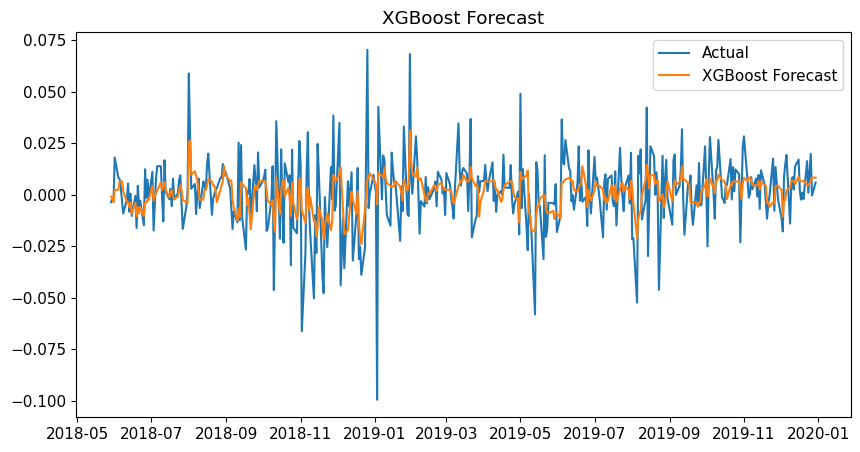

In [95]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_train.index, xgb_train_pred, label='XGBoost Forecast')
plt.plot(y_test.index, xgb_test_pred, label='XGBoost Forecast')
plt.legend()
plt.title("XGBoost Forecast")
plt.show()


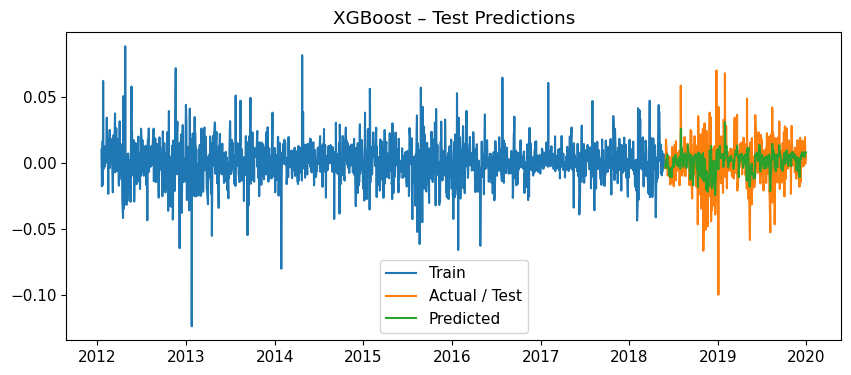

In [98]:
plt.figure(figsize=(10,4))
plt.plot(y_train.index, y_train.values, label='Train')
plt.plot(y_test.index, y_test.values, label='Actual / Test')
plt.plot(y_test.index, xgb_test_pred, label='Predicted')
plt.legend()
plt.title('XGBoost – Test Predictions')
plt.show()

#### Hyperparameter Tuning Regularized XGBoost

In [452]:
tuned_xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=5,
    gamma=2,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)


In [454]:
# Training with early stopping to prevent memorization
tuned_xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
   # early_stopping_rounds=30,
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [456]:
tuned_train_pred = tuned_xgb_model.predict(X_train)
tuned_test_pred  = tuned_xgb_model.predict(X_test)

In [457]:
train_mae = mean_absolute_error(y_train, tuned_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, tuned_train_pred))

test_mae = mean_absolute_error(y_test, tuned_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, tuned_test_pred))

print("XGBoost Train MAE:", train_mae)
print("XGBoost Train RMSE:", train_rmse)
print("XGBoost Test MAE:", test_mae)
print("XGBoost Test RMSE:", test_rmse)


XGBoost Train MAE: 0.011136530626271823
XGBoost Train RMSE: 0.015768917481731464
XGBoost Test MAE: 0.012402584803288826
XGBoost Test RMSE: 0.017590097170257456


In [474]:
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(tuned_xgb_model, f)

print("xgboost_model.pkl saved successfully")

xgboost_model.pkl saved successfully


In [475]:
with open("models/xgboost_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

print(type(loaded_xgb_model))

EOFError: Ran out of input

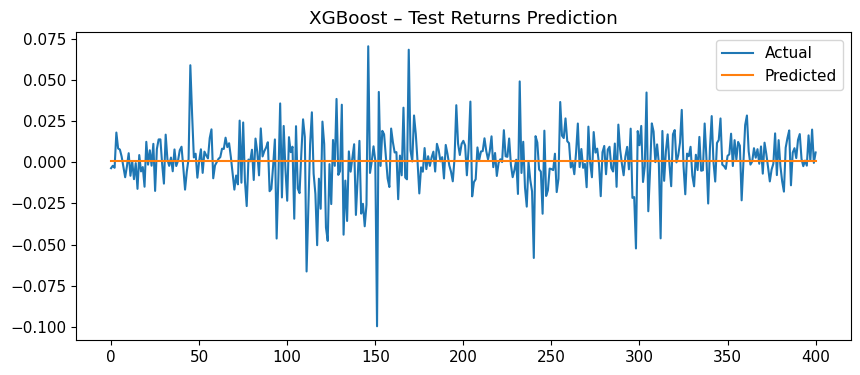

In [459]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label='Actual')
plt.plot(tuned_test_pred, label='Predicted')
plt.legend()
plt.title("XGBoost – Test Returns Prediction")
plt.show()


In [462]:
residuals = y_test - tuned_test_pred
print("Residual mean:", residuals.mean())

Residual mean: 0.000408886814964357


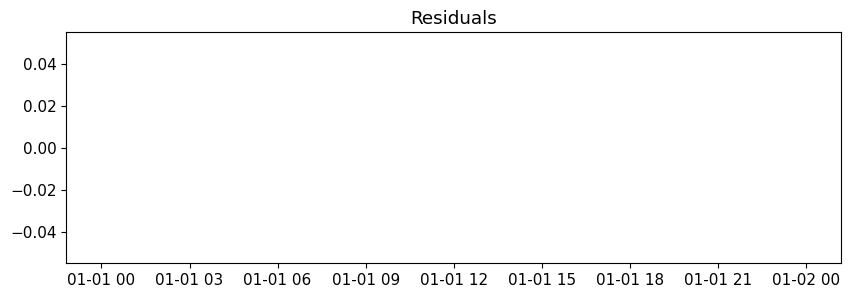

Residual mean: nan


In [460]:
residuals = y_test - test_pred

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

print("Residual mean:", residuals.mean())



<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

| Metric   | XGBoost   | Tuned XGBoost  | 
| -------- | -----     | ---------      | 
| **MAE**  | 0.0108    | **0.0124**     | 
| **RMSE** | 0.0152    | **0.0175**     | 
    
* Numbers clearly show an improvement train is approximately eaquls to test that means no overfitting.
* Model is capturing true short term trends.
* Regularization controlled overfitting, and recursive forecasting was used for multi-step prediction. Train and test errors are close, confirming good generalization.  
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [477]:
import os

if os.path.exists("models/xgboost_model.pkl"):
    os.remove("models/xgboost_model.pkl")


In [478]:
print(tuned_xgb_model)
print(type(tuned_xgb_model))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
<class 'xgboost.sklearn.XGBRegressor'>


In [480]:
import pickle
import os

os.makedirs("models", exist_ok=True)

with open("models/xgboost_model.pkl", "wb") as f:
    pickle.dump(tuned_xgb_model, f, protocol=pickle.HIGHEST_PROTOCOL)

print("xgboost_model.pkl saved successfully")



xgboost_model.pkl saved successfully


In [482]:
with open("models/xgboost_model.pkl", "rb") as f:
    test_model = pickle.load(f)

print("Pickle file loaded successfully")
print(type(test_model))


Pickle file loaded successfully
<class 'xgboost.sklearn.XGBRegressor'>


In [1]:
!pip install streamlit

your url is: https://twelve-trams-report.loca.lt


'streamlit' is not recognized as an internal or external command,
operable program or batch file.
npm WARN exec The following package was not found and will be installed: localtunnel
npm notice 
npm notice New major version of npm available! 8.1.2 -> 11.7.0
npm notice Changelog: <https://github.com/npm/cli/releases/tag/v11.7.0>
npm notice Run `npm install -g npm@11.7.0` to update!
npm notice 
